# CERN Electron Collision Data

**Context**

This dataset contains 100k dielectron events in the invariant mass range 2-110 GeV for use in outreach and education. These data were selected for use in education and outreach and contain a subset of the total event information. The selection criteria may be different from that used in CMS physics results.

**Content**

- 1) Run: The run number of the event.
- 2) Event: The event number.
- 3, 11) E1, E2: The total energy of the electron (GeV) for electrons 1 and 2.
- 4, 5, 6, 12, 13, 14) px1,py1,pz1,px2,py2,pz2: The components of the momemtum of the electron 1 and 2 (GeV).
- 7, 15) pt1, pt2: The transverse momentum of the electron 1 and 2 (GeV).
- 8, 16) eta1, eta2: The pseudorapidity of the electron 1 and 2.
- 9, 17) phi1, phi2: The phi angle of the electron 1 and 2 (rad).
- 10, 18) Q1, Q2: The charge of the electron 1 and 2.
- 19) M: The invariant mass of two electrons (GeV).

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


# Preprocess Dataset

In [ ]:
# Upload the dataset
df_dielectron = pd.read_csv('/content/drive/MyDrive/GITHUB/5_CERN/dielectron.csv')

In [ ]:
#print(df_dielectron.head(3))
#df_dielectron.dtypes
df_dielectron.info()
#df_dielectron.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB


In [ ]:
# Delte rows in which M is Nan
df_dielectron = df_dielectron.dropna(subset=["M"])

# Delete non relevant columns for the ANN
df_dielectron = df_dielectron.drop(columns=["Run", "Event", "pt1", "pt2"])

# Check that there aren't Nan
assert df_dielectron.isnull().sum().sum() == 0

In [ ]:
df_dielectron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99915 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E1      99915 non-null  float64
 1   px1     99915 non-null  float64
 2   py1     99915 non-null  float64
 3   pz1     99915 non-null  float64
 4   eta1    99915 non-null  float64
 5   phi1    99915 non-null  float64
 6   Q1      99915 non-null  int64  
 7   E2      99915 non-null  float64
 8   px2     99915 non-null  float64
 9   py2     99915 non-null  float64
 10  pz2     99915 non-null  float64
 11  eta2    99915 non-null  float64
 12  phi2    99915 non-null  float64
 13  Q2      99915 non-null  int64  
 14  M       99915 non-null  float64
dtypes: float64(13), int64(2)
memory usage: 12.2 MB


# Split Dataset

In [ ]:
# Apply percentage
train_size = 85 / 100
validation_size = 14.8 / 100
test_size = 1 - train_size - validation_size

# Separate features and target
X = df_dielectron.drop(columns=["M"])
y = df_dielectron["M"]

# Step 1: prepare test df
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42
)

# Step 2: Prepare train and validation
validation_relative_size = validation_size / (train_size + validation_size)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=validation_relative_size, random_state=42
)

# Step 3: Check sizes
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")
print(f"Total: {len(X_train) + len(X_val) + len(X_test)} samples")

Train: 84927 samples
Validation: 14788 samples
Test: 200 samples
Total: 99915 samples


# Scale Variables

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Only scale training df
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test with the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Prepare and Train the ANN

In [ ]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train_scaled, y_train,                    # Training data
    validation_data=(X_val_scaled, y_val),      # Data to validate the model in each epoch
    epochs=300,
    batch_size=32,                              # Number of samples that process the model before weighs are updated
    verbose=1                                   # 0, silence // 1,full progress // 2, per epoch
)

Epoch 1/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 258.7040 - mae: 9.9825 - val_loss: 20.0181 - val_mae: 3.0962
Epoch 2/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 15.8731 - mae: 2.7754 - val_loss: 9.5330 - val_mae: 2.1088
Epoch 3/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 8.4438 - mae: 2.0032 - val_loss: 7.0714 - val_mae: 1.8011
Epoch 4/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.4561 - mae: 1.6914 - val_loss: 4.4551 - val_mae: 1.3646
Epoch 5/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 4.6742 - mae: 1.4118 - val_loss: 4.2532 - val_mae: 1.2939
Epoch 6/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.0467 - mae: 1.2927 - val_loss: 4.2439 - val_mae: 1.3430
Epoch 7/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.1307 - mae: 1.2714 - val_loss: 2.9063 - val_mae: 1.0644
Epoch 8/300
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.2918 - mae: 1.1405 - val_loss: 4.6473 - val_mae: 1.3875
Epoch 9/300
2654/2654 ━━━

In [ ]:
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Mean Absolute Error en test: {mae:.2f} mass units")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6747 - mae: 0.4364 
Mean Absolute Error en test: 0.43 mass units


# Visualization

**Error Evolution Plot**

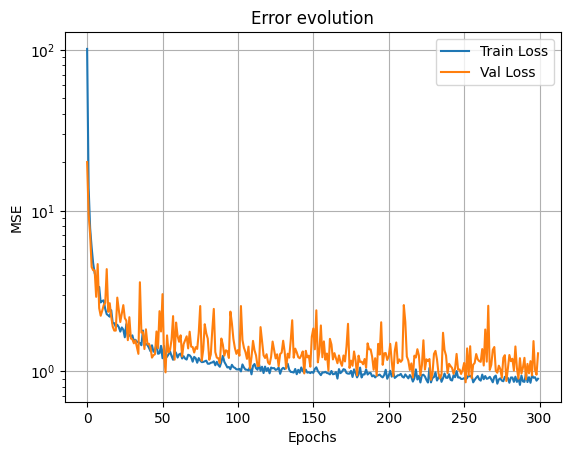

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.title("Error evolution")
plt.show()

**Predictions made by the model using test df (not used during training)**

In [ ]:
y_pred = model.predict(X_test_scaled).flatten()

for i in range(len(y_test)):
    real = y_test.iloc[i]
    pred = y_pred[i]
    error_abs = abs(real - pred)
    error_rel = error_abs / abs(real) if real != 0 else np.nan  # avoid dividing by 0
"""
    print(f"Example {i+1}: Real = {real:.3f}, Predict = {pred:.3f}, "
          f"Error Abs = {error_abs:.3f}, Error Rel = {error_rel:.2%}")
"""

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


'\n    print(f"Example {i+1}: Real = {real:.3f}, Predict = {pred:.3f}, "\n          f"Error Abs = {error_abs:.3f}, Error Rel = {error_rel:.2%}")\n'

**Prediction vs Real (perfect diagonal)**

- It shows how far are the predictions from reality
- If the points close to the red line, predictions made by trained model are ok

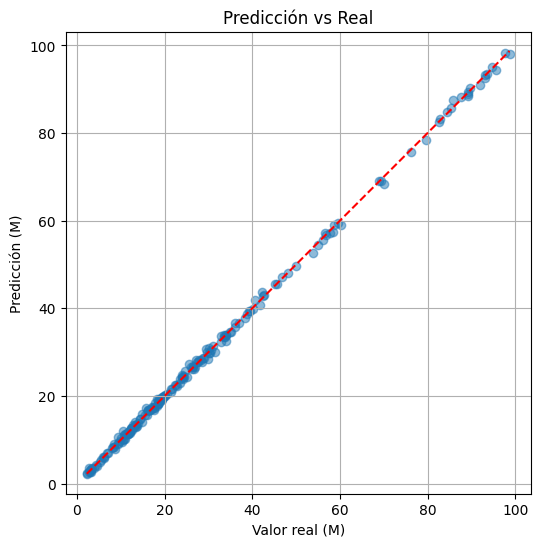

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Real Value (M)')
plt.ylabel('Prediction (M)')
plt.title('Prediction vs Real')
plt.grid(True)
plt.axis('equal')
plt.show()

**Histogram of Absolute Error**

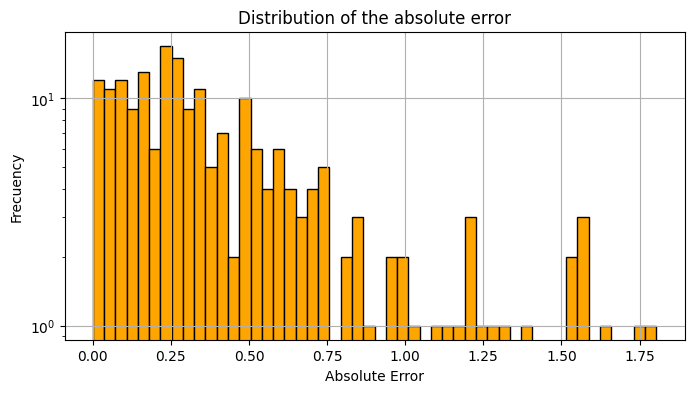

In [ ]:
error_abs = np.abs(y_test.values - y_pred)

plt.figure(figsize=(8,4))
plt.hist(error_abs, bins=50, color='orange', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frecuency')
plt.yscale('log')
plt.title('Distribution of the absolute error')
plt.grid(True)
plt.show()

**Histogram of Relative Error**

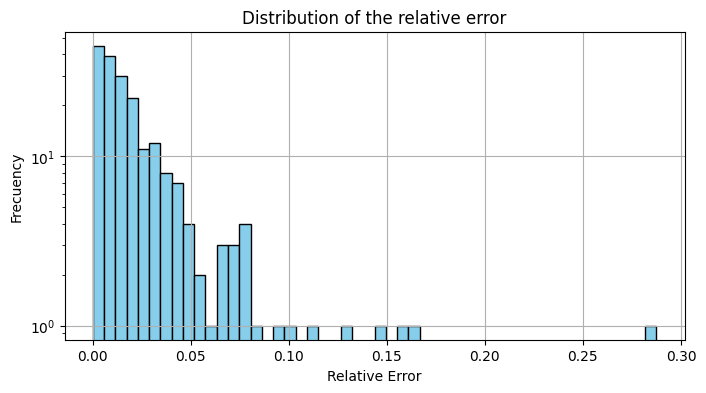

In [ ]:
error_rel = np.abs((y_test.values - y_pred) / y_test.values)

plt.figure(figsize=(8,4))
plt.hist(error_rel[~np.isnan(error_rel)], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Relative Error')
plt.ylabel('Frecuency')
plt.yscale('log')
plt.title('Distribution of the relative error')
plt.grid(True)
plt.show()

**Absolute error vs Real value**

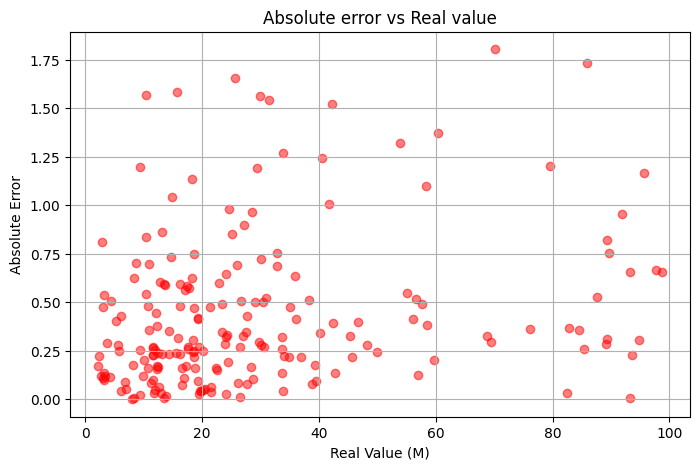

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, error_abs, alpha=0.5, color='red')
plt.xlabel('Real Value (M)')
plt.ylabel('Absolute Error')
plt.title('Absolute error vs Real value')
plt.grid(True)
plt.show()

**Absolute Error Boxplot**

1. Box: From the 1st quartile (Q1) to the 3rd quartile (Q3): Contains the 50% most common errors.
2. Center line (Q2 / median): Mean value of the absolute error.
3. Whiskers: Errors within a reasonable range (default, 1.5 * IQR).
4. Points outside the boxplot: Outliers or atypically large errors → very poor predictions.

A very narrow box means the model has very consistent errors (good).

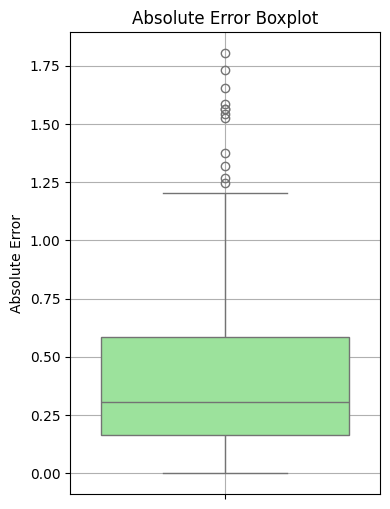

In [ ]:
plt.figure(figsize=(4,6))
sns.boxplot(y=error_abs, color='lightgreen')
plt.ylabel('Absolute Error')
plt.title('Absolute Error Boxplot')
plt.grid(True)
plt.show()

**Check worst predictions**

In [ ]:
real_values = y_test.values
pred_values = y_pred
error_abs = np.abs(real_values - pred_values)
error_rel = error_abs / np.abs(real_values)

# Create a Dataframe with the results
results_df = pd.DataFrame({
    'M_real': real_values,
    'M_pred': pred_values,
    'Error_abs': error_abs,
    'Error_rel': error_rel
})

# Sort by descending abs error
results_df_sorted = results_df.sort_values(by='Error_abs', ascending=False)
print("Top 10 worst predictions (per absolute error):")
print(results_df_sorted.head(10).to_string(index=False, float_format="%.3f"))

Top 10 worst predictions (per absolute error):
 M_real  M_pred  Error_abs  Error_rel
 70.086  68.282      1.804      0.026
 85.859  87.592      1.733      0.020
 25.668  27.324      1.656      0.065
 15.779  17.364      1.585      0.100
 10.511  12.077      1.566      0.149
 29.978  28.413      1.565      0.052
 31.561  30.017      1.544      0.049
 42.175  43.698      1.523      0.036
 60.367  58.993      1.373      0.023
 53.902  52.582      1.320      0.024


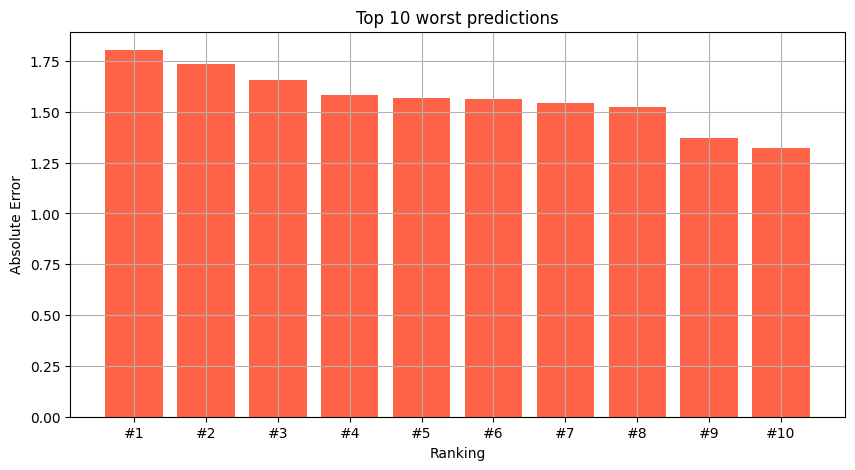

In [ ]:
top_n = 10
top_errors = results_df_sorted.head(top_n)

plt.figure(figsize=(10,5))
plt.bar(range(top_n), top_errors['Error_abs'], tick_label=[f"#{i+1}" for i in range(top_n)], color='tomato')
plt.ylabel("Absolute Error")
plt.xlabel("Ranking")
plt.title(f"Top {top_n} worst predictions")
plt.grid(True)
plt.show()

**Correlation Matrix**

What to look for in this matrix?

- Variables highly correlated with M (values ​​close to +1 or -1): possibly very relevant to the model.

- Variables highly correlated with each other (between features): could be redundant and could affect training or interpretation.

- Values ​​close to 0 → there is no linear correlation (although there may still be a nonlinear relationship, which neural networks can capture).

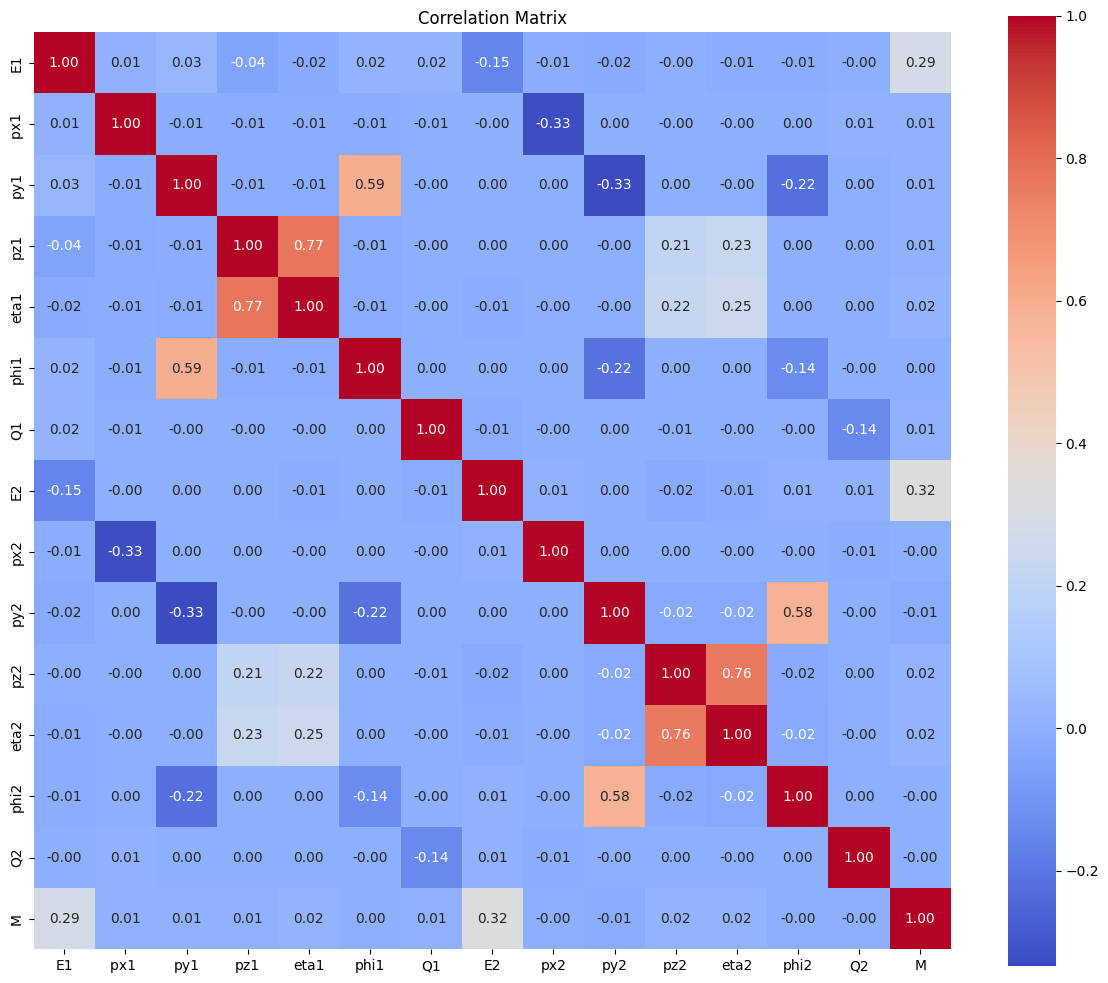

In [ ]:
# Function to calculate correlation matrix
corr_matrix = df_dielectron.corr()

# Plot the map
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True) #plasma, inferno, viridis...
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()